# Count Vectorizer demo

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet

In [2]:
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sanza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sanza\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\sanza\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
# This a notebook we use as a baseline: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification
df = pd.read_csv("bbc_text_cls.csv")
df.head() # Each row is a full article and the second column is a class

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [5]:
inputs = df["text"]
labels = df["labels"]

<AxesSubplot:>

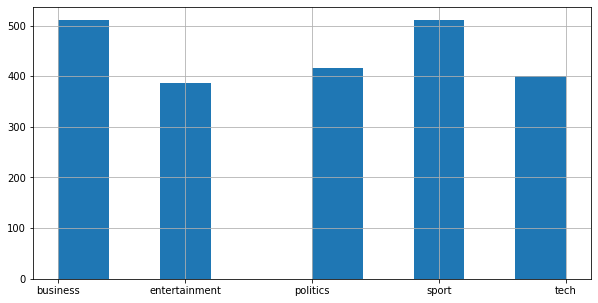

In [6]:
labels.hist(figsize = (10, 5)) # It's quite balanced

In [7]:
# Train test split BEFORE the count vectorizer, I only count on train set

inputs_train, inputs_test, y_train, y_test = train_test_split(inputs, labels, random_state = 123)

In [8]:
# Now count

vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(inputs_train)
x_test = vectorizer.transform(inputs_test)

In [30]:
# This will be a sparse matrix because most of the words are not used in many texts

print((x_train != 0).sum()/np.prod(x_train.shape)) # This is the proportion of non-zero elements (0.8%)
x_train

0.007695239935415004


<1668x26287 sparse matrix of type '<class 'numpy.int64'>'
	with 337411 stored elements in Compressed Sparse Row format>

In [31]:
# Now let's classify a bit

model = MultinomialNB()

model.fit(x_train, y_train)
print("Train score = ", model.score(x_train, y_train))
print("Test score = ", model.score(x_test, y_test))

Train score =  0.9922062350119905
Test score =  0.9712746858168761


And the scores are pretty good but probably we can improve it a bit. Remove stopwords, lemmatize, etc.

In [47]:
# With stopwords I can improve the accuracy a bit

vectorizer = CountVectorizer(stop_words = "english")
x_train = vectorizer.fit_transform(inputs_train)
x_test = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(x_train, y_train)
print("Train score = ", model.score(x_train, y_train))
print("Test score = ", model.score(x_test, y_test))
print("Size of x_train is: ", x_train.shape) # The shape will be different if we perform different stemming/lemmatization or anything like that

Train score =  0.9928057553956835
Test score =  0.9766606822262118
Size of x_train is:  (1668, 25995)


In [33]:
def get_wordnet_pos(treebank_tag):
    """NLTK and the lemmatizer are not compatible off the shelf, convert the tags to avoid typing every time"""

    if treebank_tag.startswith("J"):
        return wordnet.ADJ

    if treebank_tag.startswith("V"):
        return wordnet.VERB

    if treebank_tag.startswith("N"):
        return wordnet.NOUN

    if treebank_tag.startswith("R"):
        return wordnet.ADV

    else:
        return wordnet.NOUN

In [37]:
# Create a class and call it as if it was a function. I want to lemmatize and tokenize automatically in one step

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos = get_wordnet_pos(tag)) for word, tag in words_and_tags]


In [46]:
# With lemmatization. It takes significantly longer to run (Lemmatization) but the accuracy doesn't improve

vectorizer = CountVectorizer(tokenizer = LemmaTokenizer())
x_train = vectorizer.fit_transform(inputs_train)
x_test = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(x_train, y_train)
print("Train score = ", model.score(x_train, y_train))
print("Test score = ", model.score(x_test, y_test))
print("Size of x_train is: ", x_train.shape)


Train score =  0.9922062350119905
Test score =  0.9676840215439856
Size of x_train is:  (1668, 26000)


In [41]:
class StemTokenizer:
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens]

In [48]:
# With Stemming. It takes a bit longer to run (Stemming) but the accuracy doesn't improve

vectorizer = CountVectorizer(tokenizer = StemTokenizer())
x_train = vectorizer.fit_transform(inputs_train)
x_test = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(x_train, y_train)
print("Train score = ", model.score(x_train, y_train))
print("Test score = ", model.score(x_test, y_test))
print("Size of x_train is: ", x_train.shape)

Train score =  0.9892086330935251
Test score =  0.9694793536804309
Size of x_train is:  (1668, 22828)


In [43]:
# Now try a stupid tokenizer

def simple_tokenizer(s):
    return s.split()

In [50]:
# Train is a bit better but the test score is the same. This is a reasonable choice

vectorizer = CountVectorizer(tokenizer = simple_tokenizer)
x_train = vectorizer.fit_transform(inputs_train)
x_test = vectorizer.transform(inputs_test)
model = MultinomialNB()
model.fit(x_train, y_train)
print("Train score = ", model.score(x_train, y_train))
print("Test score = ", model.score(x_test, y_test))
print("Size of x_train is: ", x_train.shape) # This is huge because we kept the full words

Train score =  0.9952038369304557
Test score =  0.9712746858168761
Size of x_train is:  (1668, 52144)
